<a href="https://colab.research.google.com/github/sanochkinl/ml2_course/blob/main/seminars/seminar_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Knowledge distillation

look into https://intellabs.github.io/distiller/knowledge_distillation.html for reference

In [ ]:
!pip install transformers datasets timm

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import random
import os
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
import torch
from torch import nn
import torch.nn.functional as F


def train_fn(train_loader, model, criterion, optimizer, epoch, device):
    losses = AverageMeter()
    # switch to train mode
    model.train()
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1000)
        optimizer.step()
        optimizer.zero_grad()

        if step % 100 == 0 or step == (len(valid_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(
                   epoch+1, step, len(train_loader), loss=losses,
                   grad_norm=grad_norm,
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    gt_labels = []
    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        gt_labels.append(labels.to('cpu').numpy())
        if step % 100 == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader),
                   loss=losses,
                   ))
    predictions = np.concatenate(preds)
    gt_labels = np.concatenate(gt_labels)
    return losses.avg, predictions, gt_labels


def inference_func(model, testloader, device):
    model.eval()
    preds = []
    gt_labels = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    for step, (images, labels) in enumerate(testloader):
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        with torch.no_grad():
            outputs = model(images)
        preds.append(outputs.softmax(1).to('cpu').numpy().argmax(1))
        gt_labels.append(labels.to('cpu').numpy())
    predictions = np.concatenate(preds)
    gt_labels = np.concatenate(gt_labels)
    return predictions, gt_labels

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip()
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#val split
train_data, val_data = train_test_split(trainset, test_size=0.25, random_state=42)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [14]:
import timm

class ResNet(nn.Module):
    def __init__(self, model_name='resnet18', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, 10)

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

In [16]:
import torch.optim as optim

teacher_model = ResNet(model_name='resnet34', pretrained=True)
teacher_model.to(device)
optimizer = optim.Adam(teacher_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):  # loop over the dataset multiple times
    # train
    avg_loss = train_fn(train_loader, teacher_model, criterion, optimizer, epoch, device)
    # eval
    avg_val_loss, preds, val_labels = valid_fn(valid_loader, teacher_model, criterion, device)
    acc_score = accuracy_score(val_labels, preds.argmax(1))
    print(f"Validation accuracy for epoch {epoch} is {acc_score:.2f}")

print('Finished Training')

Epoch: [1][0/586] Loss: 2.2497(2.2497) Grad: 6.5535  
Epoch: [1][100/586] Loss: 1.4357(1.9442) Grad: 2.7849  
Epoch: [1][195/586] Loss: 1.2274(1.6479) Grad: 2.7652  
Epoch: [1][200/586] Loss: 1.3355(1.6369) Grad: 3.2524  
Epoch: [1][300/586] Loss: 1.2439(1.4538) Grad: 2.1474  
Epoch: [1][400/586] Loss: 0.8965(1.3249) Grad: 1.9394  
Epoch: [1][500/586] Loss: 0.9076(1.2311) Grad: 2.2591  
EVAL: [0/196] Loss: 0.6541(0.6541) 
EVAL: [100/196] Loss: 0.8874(0.7292) 
EVAL: [195/196] Loss: 1.0097(0.7312) 
Validation accuracy for epoch 0 is 0.75
Epoch: [2][0/586] Loss: 0.6220(0.6220) Grad: 1.6075  
Epoch: [2][100/586] Loss: 0.6498(0.6661) Grad: 2.0414  
Epoch: [2][195/586] Loss: 0.5228(0.6557) Grad: 1.5723  
Epoch: [2][200/586] Loss: 0.9139(0.6547) Grad: 2.1913  
Epoch: [2][300/586] Loss: 0.6079(0.6547) Grad: 1.5550  
Epoch: [2][400/586] Loss: 0.6828(0.6455) Grad: 1.7500  
Epoch: [2][500/586] Loss: 0.6820(0.6374) Grad: 1.6213  
EVAL: [0/196] Loss: 0.4128(0.4128) 
EVAL: [100/196] Loss: 0.6843(0.5

Knowledge distillation pipeline

<Axes: >

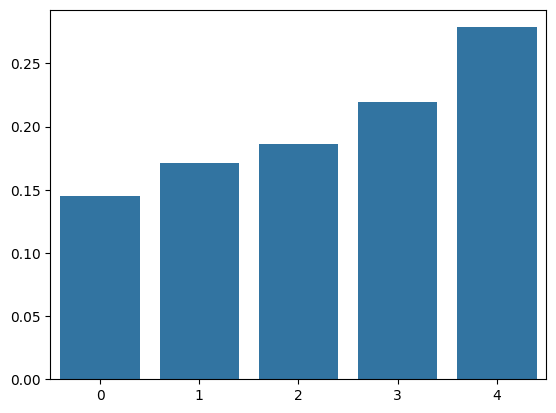

In [75]:
# @title Temperature Illustration { run: "auto" }
from seaborn import barplot

temp = 1.21 # @param {type:"slider", min:0.01, max:100, step:0.1}

barplot(F.softmax(torch.tensor([0.1, 0.3, 0.4, 0.6, 0.89]) / temp, dim=0).numpy())

In [46]:
import torch.nn as nn
import torch.nn.functional as F


def calculate_kd_loss(logits_student, logits_teacher, y_true, temp=1, distil_weight=.5):
    soft_teacher_out = F.softmax(logits_teacher, dim=1)
    soft_student_out = F.softmax(logits_student, dim=1)
    student_loss = F.cross_entropy(logits_student, y_true)
    distillation_loss =  F.cross_entropy(
        soft_student_out / temp, soft_teacher_out / temp
    ) * temp**2
    return (1 - distil_weight) * student_loss + distil_weight * distillation_loss


def train_student_with_kd(
        train_loader,
        criterion,
        optimizer,
        epochs,
        device,
        student_model,
        teacher_model,
    ):
        teacher_model.eval()
        student_model.train()

        print("Training Student...")

        for ep in range(epochs):
            epoch_loss = 0.0
            correct = 0

            for (data, label) in train_loader:

                data = data.to(device)
                label = label.to(device)

                student_out = student_model(data)
                teacher_out = teacher_model(data)

                loss = criterion(student_out, teacher_out, label)

                if isinstance(student_out, tuple):
                    student_out = student_out[0]

                pred = student_out.argmax(dim=1, keepdim=True)
                correct += pred.eq(label.view_as(pred)).sum().item()

                loss.backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(student_model.parameters(), 1000)
                optimizer.step()
                optimizer.zero_grad()

                epoch_loss += loss.item()

            _, preds, val_labels = valid_fn(valid_loader, student_model, nn.CrossEntropyLoss(), device)
            acc_score = accuracy_score(val_labels, preds.argmax(1))
            print(f"Validation accuracy for epoch {ep} is {acc_score:.2f}")



In [48]:
from functools import partial

student_model = ResNet(model_name='resnet18', pretrained=True)
student_model.to(device)
optimizer = optim.Adam(student_model.parameters(), lr=1e-3)
train_student_with_kd(
    train_loader,
    partial(calculate_kd_loss, temp=2, distil_weight=0.8),
    optimizer,
    10,
    device,
    student_model,
    teacher_model,
)

Training Student...
EVAL: [0/196] Loss: 0.5785(0.5785) 
EVAL: [100/196] Loss: 0.7044(0.7113) 
EVAL: [195/196] Loss: 1.2737(0.7134) 
Validation accuracy for epoch 0 is 0.75
EVAL: [0/196] Loss: 0.6966(0.6966) 
EVAL: [100/196] Loss: 0.7143(0.7244) 
EVAL: [195/196] Loss: 1.0807(0.7322) 
Validation accuracy for epoch 1 is 0.76
EVAL: [0/196] Loss: 0.5887(0.5887) 
EVAL: [100/196] Loss: 0.7085(0.6493) 
EVAL: [195/196] Loss: 0.8057(0.6611) 
Validation accuracy for epoch 2 is 0.79
EVAL: [0/196] Loss: 0.5028(0.5028) 
EVAL: [100/196] Loss: 0.5726(0.5860) 
EVAL: [195/196] Loss: 0.9814(0.5996) 
Validation accuracy for epoch 3 is 0.80
EVAL: [0/196] Loss: 0.5375(0.5375) 
EVAL: [100/196] Loss: 0.8499(0.6877) 
EVAL: [195/196] Loss: 1.1250(0.7013) 
Validation accuracy for epoch 4 is 0.79
EVAL: [0/196] Loss: 0.7315(0.7315) 
EVAL: [100/196] Loss: 0.7271(0.6848) 
EVAL: [195/196] Loss: 1.2397(0.6859) 
Validation accuracy for epoch 5 is 0.79
EVAL: [0/196] Loss: 0.5790(0.5790) 
EVAL: [100/196] Loss: 0.7438(0.6

## Active learning

In [ ]:
%pylab inline

from typing import Callable, Sequence, Tuple, Optional
from random import sample

from sklearn.linear_model import LogisticRegression
from scipy.stats import multivariate_normal, ortho_group
import seaborn as sns

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
sns.set_style("white")
colors = sns.color_palette(n_colors=10)

# Sample 2d data from two Gaussians

The means are chosen to make the data is linearly separable.

- Move the gaussians closer together to see how active learning would deal with non-linearly separable data.
- Play with the seeds to get different shapes of the gaussians.

In [ ]:
def sample_covar(dim: int = 2, scale_min: float =  .3, scale_max: float = 5) -> np.ndarray:
  """Construct random covariance matrix by sampling a rotation and scale matrix."""
  R = ortho_group.rvs(dim) * (rand(dim, dim) * (scale_max - scale_min) + scale_min)
  return R.dot(R.T)

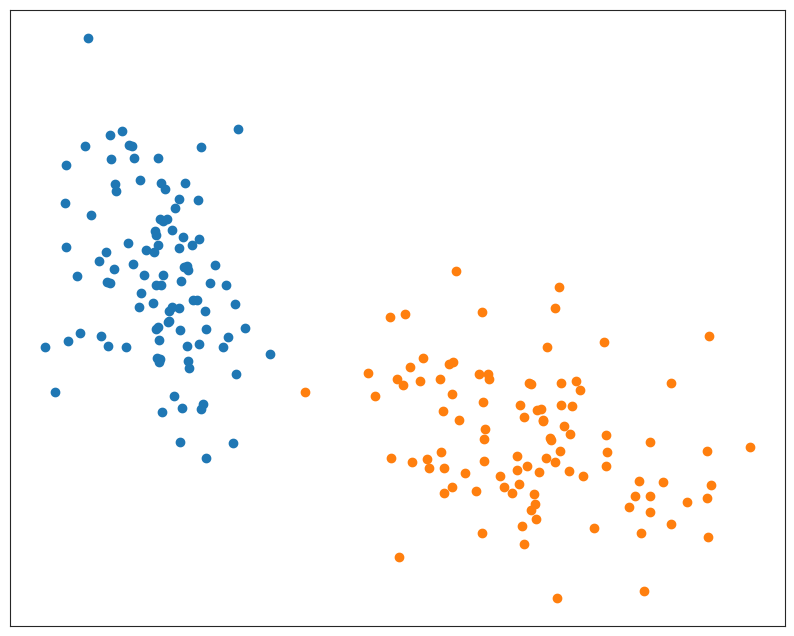

In [ ]:
N_1, N_2 = 100, 100  # number of samples in each point cloud
mu_1 = [-5, 2]  # centroid of the first point cloud
mu_2 = [5, -2]  # centroid of the second point cloud

random.seed(23)

X = np.concatenate([
  multivariate_normal(mu_1, sample_covar()).rvs(N_1),
  multivariate_normal(mu_2, sample_covar()).rvs(N_2),
])
y = np.concatenate([zeros(N_1, int), ones(N_2, int)])

# show a scatter plot of the data
figure(figsize=(10,8))
scatter(X[y==0, 0], X[y==0, 1], color=colors[0])
scatter(X[y==1, 0], X[y==1, 1], color=colors[1])
xticks(()), yticks(());

## Helper functions for plotting data and classifier

In [ ]:
def meshgrid_from_bounds(lower_left: Sequence[float], upper_right: Sequence[float], *,
                         resolution: float = 0.02) -> Tuple[np.ndarray, np.ndarray]:
  """Return a meshgrid that covers the range from lower_left to upper_right."""
  return meshgrid(arange(lower_left[0], upper_right[0], resolution),
                  arange(lower_left[1], upper_right[1], resolution))

def plot_decision_boundary(clf, lower_left: Sequence[float], upper_right: Sequence[float], *,
                           resolution: float = 0.02, boundary_color: Tuple[float] = (0.2, 0.2, 0.2)):
  """Plot decision boundary of a given classifier in the given range.
  
     Args:
        clf: The classifier to evaluate.
        lower_left: Lower left coordinate of the plotting range.
        upper_right: Upper right coordinate of the plotting range.
  """
  xx, yy = meshgrid_from_bounds(lower_left, upper_right, resolution=resolution)
  Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0].reshape(xx.shape)
  contour(xx, yy, Z, levels=[0.5], colors=[boundary_color])

def lighten(color: Tuple[float], *, amount: float = .6):
  """Blend color with white by the given amount."""
  return tuple(array(color) * (1 - amount) + array([1, 1, 1]) * amount)

In [ ]:
def plot_data(X: np.ndarray, y: np.ndarray, train_idx: Sequence[int], *,
              colors: Sequence[Tuple[float]] = sns.color_palette(n_colors=2)):
  """Scatter plot of the training and unlabeled data.

     Args:
        X, y: Data and associated labels.
        train_idx: Indices of the training data.
        colors: Plotting colors of the two classes."""
  # show all data
  scatter(X[y==0, 0], X[y==0, 1], color=lighten(colors[0]), s=6)
  scatter(X[y==1, 0], X[y==1, 1], color=lighten(colors[1]), s=6)

  # show training data
  X_tr = X[train_idx]
  y_tr = y[train_idx]
  scatter(X_tr[y_tr==0, 0], X_tr[y_tr==0, 1], color=colors[0])
  scatter(X_tr[y_tr==1, 0], X_tr[y_tr==1, 1], color=colors[1])
  xticks(()), yticks(());

def plot_data_and_classifier(X: np.ndarray, y: np.ndarray, train_idx: Sequence[int], clf, *,
                             previous_clf=None, colors: Sequence[Tuple[float]] = sns.color_palette(n_colors=2)):
  """Scatter plot of the training and unlabeled data and the decision boundary of the classifier.

     Also draws decsion boundary of the classifier from the previous round (if given).

     Args:
        X, y: Data and associated labels.
        train_idx: Indices of the training data.
        clf: Classifier trained on training data.
        pervious_clf: Classifier trained on training data in the last round.
        colors: Plotting colors of the two classes.
  """
  if previous_clf is not None:
    plot_decision_boundary(previous_clf, lower_left=X.min(axis=0) - 1, upper_right=X.max(axis=0) + 1, boundary_color=(0.7, 0.7, 0.7))

  plot_decision_boundary(clf, lower_left=X.min(axis=0) - 1, upper_right=X.max(axis=0) + 1)
  plot_data(X, y, train_idx, colors=colors)


## Non-active learning

Train a logistic regression classifier on 10 randomly sampled training examples.

**Note:** we cherry-picked an example where the training went wrong - play with the seed (or remove it) to see different results.


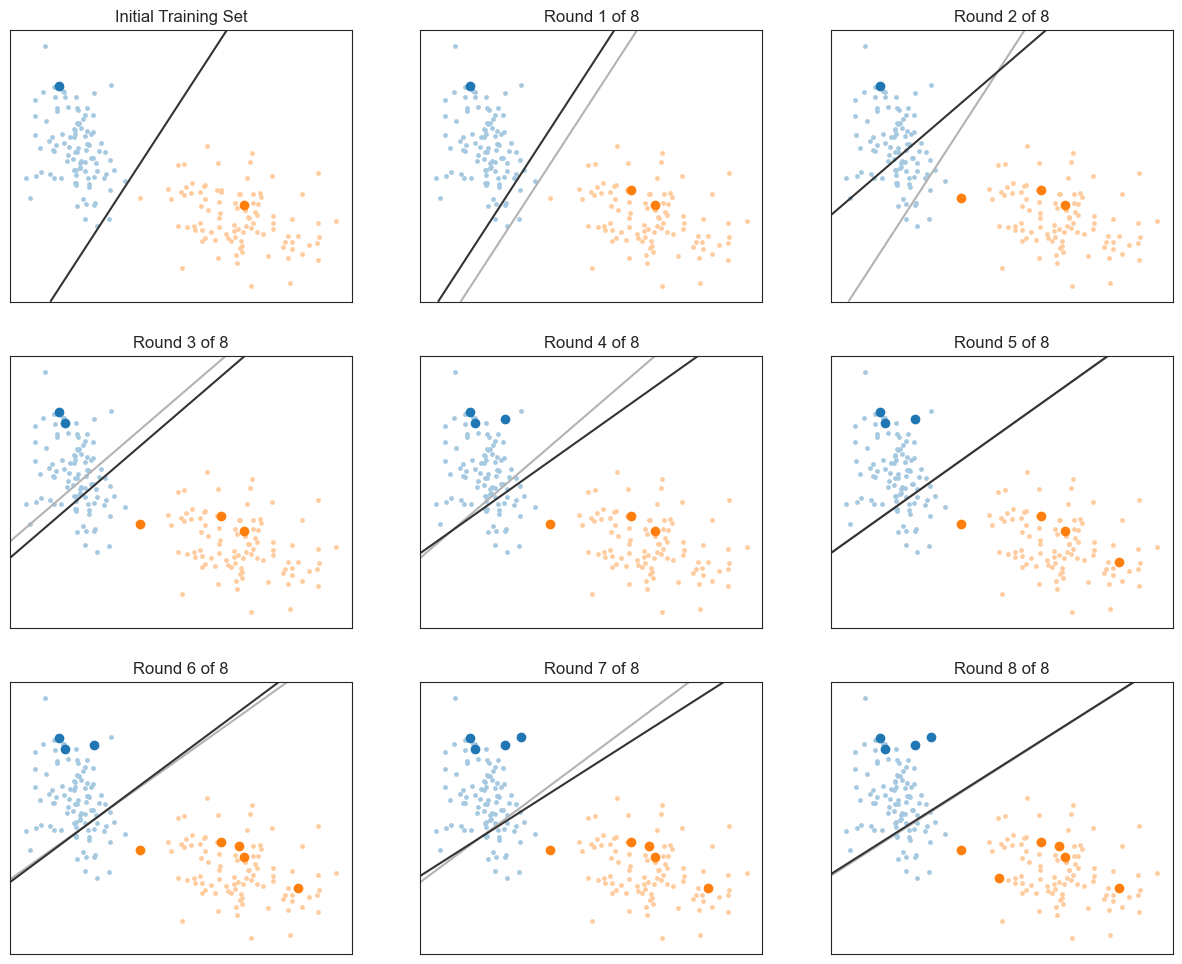

In [ ]:
random.seed(112818)  # cherry-pick a seed of a bad example

# start with one sample from either class
starting_samples = [choice(range(N_1)), N_1 + choice(range(N_2))]
train_idx = starting_samples[:]
clf = LogisticRegression().fit(X[train_idx], y[train_idx])

# ...  and randomly sample 8 additional training samples
figure(figsize=(15, 12))
subplot(3, 3, 1)
title(f'Initial Training Set')
plot_data_and_classifier(X, y, train_idx, clf)

for round in range(8):
  new_sample = choice([i for i in range(N_1 + N_2) if i not in train_idx])
  train_idx.append(new_sample)
  previous_clf = clf
  clf = LogisticRegression().fit(X[train_idx], y[train_idx])
  
  ax = subplot(3, 3, round+2)
  title(f'Round {round + 1} of 8')
  plot_data_and_classifier(X, y, train_idx, clf, previous_clf=previous_clf)

## Active learning with uncertainty sampling

Starting with one sample from either class as above, iteratively get the label of a sample where the model is most uncertain about the class until 10 samples are drawn.

In [ ]:
from scipy.stats import entropy

def least_confidence(posterior: np.ndarray) -> np.ndarray:
  """Least confidence criterion, u(x) = 1 - max P(y | x).

     Args:
        posterior: Estimated class probabilities - ndarray of shape (n_samples, n_classes).
    
     Returns:
        Least-confidence score.
  """
  return 1 - posterior.max(axis=1)


def minimum_margin(posterior: np.ndarray) -> np.ndarray:
  """Minumum margin criterion, u(x) = P(y_2* | x) - P(y_1* | x), where y_1* and y_2* are the two most probable classes.

     Args:
        posterior: Estimated class probabilities - ndarray of shape (n_samples, n_classes).
    
     Returns:
        Minumum margin score.
  """
  most_probable = posterior.max(axis=1)
  # hack to get the second highest posterior probability
  mask_most_probable = (posterior == most_probable.reshape(-1, 1))
  second_most_probable = (posterior - mask_most_probable).max(axis=1)
  return second_most_probable - most_probable


def entropy_criterion(posterior: np.ndarray) -> np.ndarray:
  """Entropy criterion, u(x) = -E[log P(y | x)].

     Args:
        posterior: Estimated class probabilities - ndarray of shape (n_samples, n_classes).
    
     Returns:
        Entropy of the posterior distribution.
  """
  return entropy(posterior, axis=1)


def uncertainty_sampling(clf, X: np.ndarray, train_idx: Sequence[int], criterion: Callable[[np.ndarray], np.ndarray]) -> int:
  """Get the index of an unknown sample where the classifier is most uncertain about the label.

     Args:
        clf: The classifier (must provide `predict_proba()`).
        X: All data (labeled and unlabeled) - ndarray of shape (n_samples, n_features).
        train_idx: Indices of the training samples.
        criterion: Sample utility that maps posterior class probabilities to sample utility.

     Returns:
        Index of the sample in X with the highest decision uncertainty that is not yet in `train_idx`.
  """
  unknown_indices = array([i for i in range(X.shape[0]) if i not in train_idx])
  posterior = clf.predict_proba(X[unknown_indices])
  utility = criterion(posterior)
  return unknown_indices[argmax(utility)]

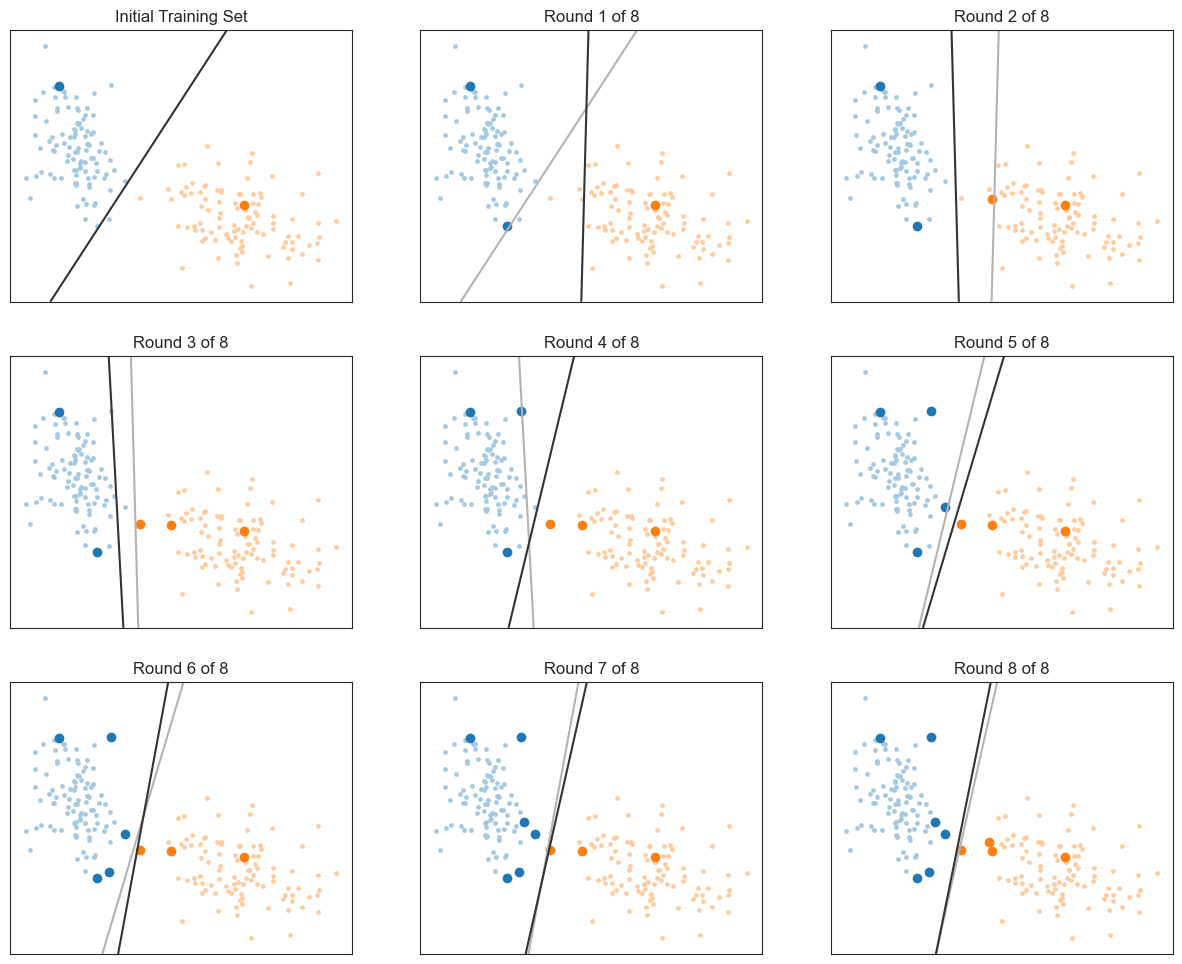

In [ ]:
# starting with the sample samples as above ...
train_idx = starting_samples[:]
clf = LogisticRegression().fit(X[train_idx], y[train_idx])

figure(figsize=(15, 12))
subplot(3, 3, 1)
title(f'Initial Training Set')
plot_data_and_classifier(X, y, train_idx, clf)

# ... do 8 rounds of uncertainty sampling
for round in range(8):
  new_sample = uncertainty_sampling(clf, X, train_idx, criterion=entropy_criterion)
  train_idx.append(new_sample)

  subplot(3, 3, round+2)
  title(f'Round {round + 1} of 8')
  previous_clf = clf
  clf = LogisticRegression().fit(X[train_idx], y[train_idx])
  plot_data_and_classifier(X, y, train_idx, clf, previous_clf=previous_clf)